In [1]:
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

# Physical variables

D = 4
packfrac = 0.2

# Non-physical parameters

sidepartnum = 6

accratio = 0.3
drmax = 1

density = packfrac / (np.pi**(D/2) * (1/2)**D / math.gamma(D/2 + 1))
partnum = sidepartnum ** D
boxlen = (partnum / density)**(1/D)
conf = np.array([
    (np.array(index) + 0.5) * density**(-1/D)
    for index in itertools.product(range(sidepartnum), repeat=D)
])

# Utils

def banner():
    print(f'''
____________________________________

            Monte-Carlo
____________________________________


D = {D}
N = {partnum}
d = {density}
L = {boxlen}

''')

# Energy

def partener(n):
    rn = conf[n]
    rvec = conf - rn
    rvec = rvec[np.arange(partnum) != n]
    rvec -= boxlen * np.round(rvec / boxlen)
    r = np.linalg.norm(rvec, axis=1)

    u = np.zeros(partnum - 1)
    dl = 50
    dT = 1.4737
    mask = r <= dl / (dl - 1)
    r = r[mask]
    u[mask] = ((dl * ( dl / (dl - 1))**(dl - 1))  / dT) * ((1 / r)**dl - (1 / r)**(dl - 1)) + 1 / dT

    return np.sum(u)

def totener():
    energies = np.array([ partener(n) for n in range(partnum) ])
    return .5 * np.sum(energies)


# Motion

def boundcond():
    conf[np.any(conf > boxlen, axis=1)] %= boxlen

def movepart(n):
    v = np.random.randn(D)
    u = v / np.linalg.norm(v)
    dr = u * np.random.rand() * drmax
    conf[n] += dr
    conf[n] %= boxlen

# MonteCarlo sex

def mloglikelihood():
    pass

def mlogprior():
    pass

def adjustdr(ratio):
    global drmax
    drmax *= 1.05 if ratio > accratio else 0.95

def sampling(iterations):
    enerchain = []
    confchain = []

    energy = totener()
    accepteds = 0
    for tries in range(1, iterations + 1):
        n = np.random.randint(partnum)
        initpos = conf[n].copy()
        initener = partener(n)
        movepart(n)
        finalener = partener(n)

        diffener = finalener - initener

        if diffener < 0 or np.exp(-diffener) > np.random.rand():
            energy += diffener
            enerchain.append(energy)
            confchain.append(conf)
            accepteds += 1
            if accepteds % partnum == 1:
                enerchain.append(energy)
                confchain.append(conf.copy())
        else:
            conf[n] = initpos.copy()

        ratio = accepteds / tries
        adjustdr(ratio)

        if tries % 1000 == 0:
            print(f'{tries}\t{energy}\t{drmax}\t{ratio}')

    return np.array(enerchain), np.array(confchain)

# Plots

def plothist(data, ax):
    counts, bins = np.histogram(data, bins=20)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bins[1] - bins[0]
    ax.bar(bin_centers, counts, width=bin_width, edgecolor='black')

def plot(conf, fn = None):
    D = conf.shape[1]
    fig, axs = plt.subplots(D, D, layout="constrained") 

    for i in range(D):
        for j in range(D):
            if j > i:
                axs[i, j].set_visible(False)
                
    for i in range(D):
        for j in range(D):
            if j < i:
                axs[i, j].set_title(f'Plane {i}{j}')
                axs[i, j].scatter(
                    conf[:, i],
                    conf[:, j],
                    marker='.',
                    alpha=0.5
                )
                
    for i in range(D):
        plothist(conf[:, i], axs[i, i])

    if fn == None:    
        plt.show()
    else:
        plt.savefig(fn)
        plt.show()


def plotheat(conf):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = conf[:, 0]
    y = conf[:, 1]
    z = conf[:, 2]
    c = conf[:, 3]

    img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
    fig.colorbar(img)
    plt.show()

def estimador_gr(conf, bins=50, r_max=None, fn = None):
    N = conf.shape[0]
    d = conf.shape[1]
    
    dists = pdist(conf)
    
    if r_max is None:
        r_max = np.max(dists)

    hist, bin_edges = np.histogram(dists, bins=bins, range=(0, r_max))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    #Volumen de las cáscaras esféricas en D dimensiones
    dr = bin_edges[1] - bin_edges[0]
    def volume_shell(r, dr, d):
        from scipy.special import gamma
        vol_d = (np.pi ** (d / 2)) / gamma(d / 2 + 1)
        return vol_d * ((r + dr/2) ** d - (r - dr/2) ** d)

    shell_volumes = np.array([volume_shell(r, dr, d) for r in bin_centers])
    
    #Volumen total aproximado (caja mínima que contiene las partículas)
    box_min = conf.min(axis=0)
    box_max = conf.max(axis=0)
    V = np.prod(box_max - box_min)

    rho = N / V
    
    #Estimador de g(r)
    norm_factor = rho * N  #número esperado de pares por unidad de volumen
    gr = hist / (norm_factor * shell_volumes)

    plt.plot(bin_centers, gr, c='cadetblue', lw = 2)
    plt.xlabel("r")
    plt.ylabel("g(r)")
    plt.title("Radial correlation function $g(r_{i}-r_{j})$")
    plt.grid(True)
    if fn == None:    
        plt.show()
    else:
        plt.savefig(fn)
        plt.show()

    return bin_centers, gr

# main

banner()
enerchain, confchain = sampling(100_000)


____________________________________

            Monte-Carlo
____________________________________


D = 4
N = 1296
d = 0.6484555753109618
L = 6.686228174096548


1000	17.535055048853344	0.1051466018386965	0.3
2000	31.61146374044714	0.08182845639997705	0.302
3000	50.316379902696454	63.55450593025614	0.29933333333333334
4000	59.256349703634996	8.163435694115629	0.30425
5000	66.7656976693747	5.200567117536074	0.2984
6000	71.62631559645439	33.108491388918495	0.301
7000	79.41348991620359	7.0144639947029885	0.3017142857142857
8000	88.43453406970112	148.4128490786819	0.301
9000	89.86802502858765	155.94724285970963	0.2986666666666667
10000	88.31553570238297	0.6666083378254243	0.2969
11000	85.60170601369727	0.05191213632967944	0.3020909090909091
12000	87.66251258595443	12.131725200384478	0.30191666666666667
13000	81.64798885392622	2.325476572546208	0.2979230769230769
14000	86.43795028181958	0.08131760491240239	0.2993571428571429
15000	89.89718216174886	0.4683899536895572	0.3012
16000	100.0789

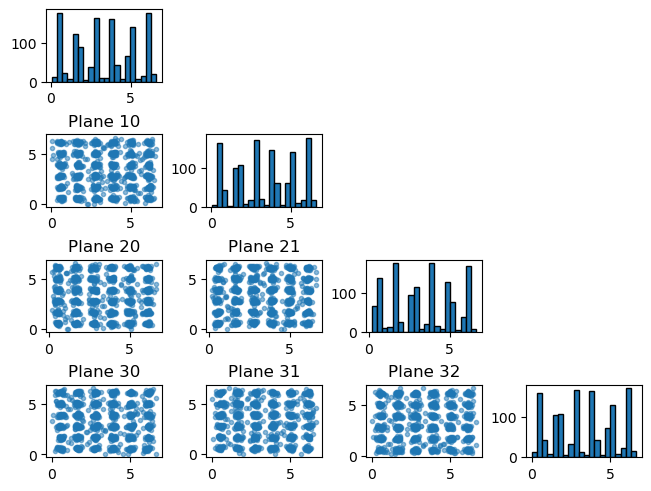

In [2]:
plot(conf)

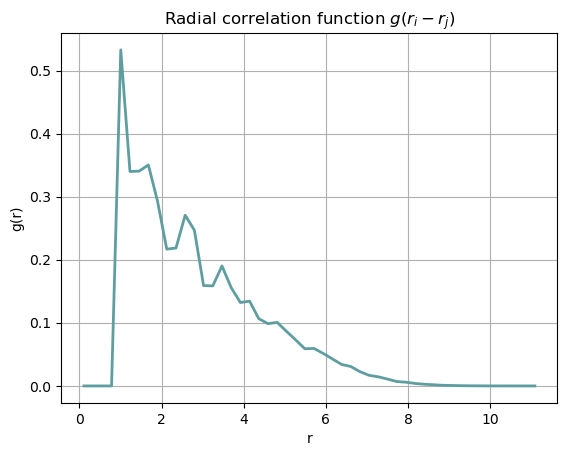

In [3]:
r, gr = estimador_gr(conf) #Estimador, devuelve distancias por bin y la función de correlación radial

# MODELADO

Esto calcula parametros del potencial PHS para ajustar su coeficiente de virial hasta concidir con el de HS

In [11]:
from scipy.integrate import quad
import math

In [27]:
D =  3
V = lambda r: np.pi**(D/2) * r**D / math.gamma(D/2 + 1) 
integrand = lambda r: r**(D - 1)
result, error = quad(integrand, 0, 1)
result * np.pi**(D / 2) / math.gamma(D / 2)

2.0943951023931957

In [29]:
V(1/2) / 2

0.2617993877991494

In [ ]:
import emcee
import corner

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1843.60it/s]


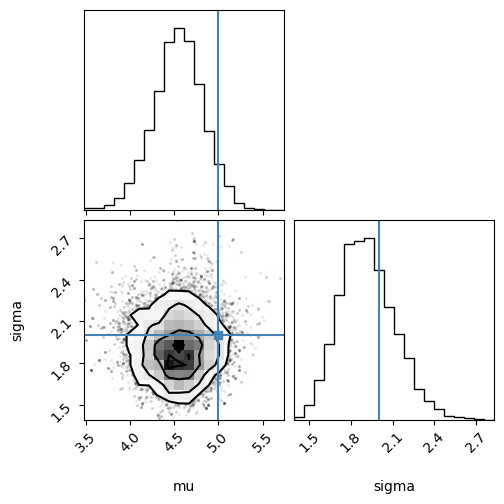

In [4]:
np.random.seed(42)


def log_likelihood(theta):
    r, a = theta
    B2_HS = 4 np.pi**2

    def u(r):
    dl = 50
    dT = 1.4737
    if r > dl / (dl - 1):
        return 0
    return ((dl * ( dl / (dl - 1))**(dl - 1))  / dT) * ((1 / r)**dl - (1 / r)**(dl - 1)) + 1 / dT


    f = lambda r: 
    result, error = quad(integrand, 0, 1)
    result * np.pi**(D / 2) / math.gamma(D / 2)
    
    BS_PHS = 

    
    chi =  np.sum(np.abs(B2_HS - B2_PHS))
    return -0.5 

def log_prior(theta):
    r, a = theta
    if 1 < r < 10 and 1 < a < 10:
        return 0.0 
    return -np.inf

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)

ndim = 2           
nwalkers = 10    
p0 = np.random.rand(nwalkers, ndim) * [10, 1] + [0, 1]  # condiciones iniciales

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(p0, 2000, progress=True)
samples = sampler.get_chain(discard=500, flat=True)

corner.corner(samples, labels=["\lambda_r", "\lambda_a"])
plt.show()

In [30]:
def u(r):
    dl = 50
    dT = 1.4737
    if r > dl / (dl - 1):
        return 0
    return ((dl * ( dl / (dl - 1))**(dl - 1))  / dT) * ((1 / r)**dl - (1 / r)**(dl - 1)) + 1 / dT



In [31]:
f = lambda r: np.exp(-u(r)) -1 

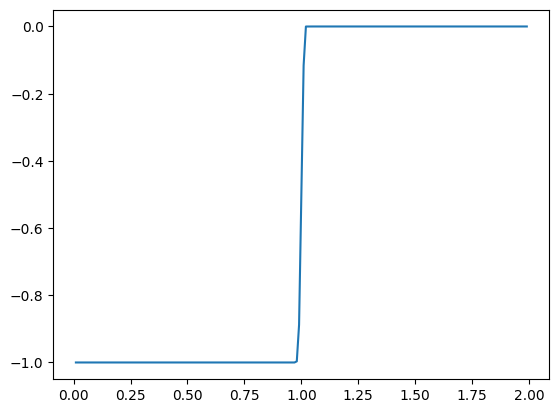

In [34]:
r = np.arange(0.01, 2, 0.01)
plt.plot(r, [f(x) for x in r])